<a href="https://colab.research.google.com/github/mhelynne/bank-project-am/blob/master/PARTE_1_Projeto_de_Aprendizagem_de_M%C3%A1quina_Maria_e_Ana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto da disciplina Aprendizagem de Máquina
Professores: Evandro Costa e Xu Yang

Alunas: Ana Correia e Helynne Lima

O banco de dados escolhido para trabalhar neste projeto foi o Bank Marketing Data Set, disponível [aqui](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

#Importação dos dados

Para importação do banco de dados, utilizamos uma cópia de sua versão completa, a qual foi hospedada no Github. O comando .head() permite conhecer as primeiras linhas do banco de dados.

In [1]:
import pandas as pd

url = 'https://github.com/mhelynne/bank-project-am/blob/master/bank/bank-full.csv?raw=true'
bank_full = pd.read_csv(url, sep=";")

bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#Análise exploratória

Este banco de dados traz um problema de classificação binária, cuja classe alvo está representada pela coluna **y**, cujos valores podem ser **yes** ou **no**. **yes** significa que o cliente aceita o depósito e **no** que não aceita.
Vamos verificar quantas instâncias de cada classe há.


In [2]:
import numpy as np

class_y, count_y = np.unique(bank_full.y.array, return_counts=True)

print(class_y)
print(count_y)

['no' 'yes']
[39922  5289]


Para permitir a criação de um gráfico de pizza, vamos definir a seguinte função, e em seguida chamá-la para ilustrar as proporções de cada classe:

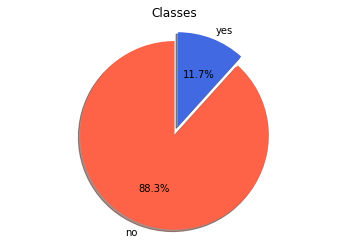

In [3]:
import matplotlib.pyplot as plt

def create_pizza(labels, sizes, title, colors = ['#FF6347', '#4169E1']) :
    fig1, ax1 = plt.subplots()
    explode = (0.1, 0)

    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, 
            autopct='%1.1f%%', shadow=True, startangle=90)
    
    ax1.axis('equal')
    ax1.set_title(title)
    plt.show()

title = 'Classes'
labels = class_y[0], class_y[1]   
create_pizza(class_y, count_y, title)

Há um claro desbalanceamento entre as classes, sendo a classe **yes** a classe minoritária com 11,7% das instâncias e a classe **no** é a classe majoritária com 88.3% das instâncias.

De acordo com a descrição da base de dados no repositório UCI, não há instâncias com valores faltando. No entanto, é válido verificar essa condição por meio dos seguinte comando:

In [4]:
if( not bank_full.isnull().values.any() ):
  print("Não há instâncias com atributos nulos ou ausentes.")

Não há instâncias com atributos nulos ou ausentes.


Segundo a descrição da base de dados no repositório UCI, o atributo **duration** deve ser desconsiderado em caso de aplicação da base para um problema de classificação. Como esse é justamente o nosso caso, faremos a remoção desse atribuito.

A justificativa encontrada no repositório UCI está a seguir:

> "**duration**: duração do último contato, em segundos (numérico). Observação importante: este atributo afeta fortemente a meta de saída (por exemplo, se duração = 0, então **y** = '**no**'). No entanto, a duração não é conhecida antes que uma chamada seja realizada. Além disso, após o fim da chamada, **y** é obviamente conhecido. Assim, essa entrada deve ser incluída apenas para fins de *benchmark* e deve ser descartada se a intenção for ter um modelo preditivo realista.



In [5]:
bank_full = bank_full.drop('duration', axis=1)

Para aprofundar a análise exploratória da base de dados, a seguir será exibido um relatório elaborado pela a biblioteca ProfileReport. O relatório completo está em anexo, no arquivo dataframe_report.html

In [ ]:
!pip install -U pandas-profiling

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(bank_full, title='Análise exploratória', 
                        html={'style':{'full_width':True}})
#profile.to_notebook_iframe()
profile.to_file(output_file="dataframe_report.html")

from google.colab import files
files.download('dataframe_report.html')

#Transformação Categórica-Numérica

A partir da análise exploratória, foi possível observar que dentre os atributos do banco de dados Bank Marketing, há 16 colunas das quais:
* Seis são atributos numéricos: **age, balance, day, campaign, pdays** e **previous**;
* Seis são atributos categóricos: **job, marital, education, contact, month** e **poutcome**;
* Quatro são atributos booleanos: **default, housing, loan** e **y**.

In [8]:
bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


No entanto, muitas técnicas e algoritmos de aprendizagem de máquina necessitam trabalhar com dados apenas númericos. Por isso, faz-se necessário transformar as variáveis categóricas em numéricas.

Inicialmente, as variáveis **education** e **month** serão transformadas de forma que, para o atributo **month**, os meses serão ordenados de 1 a 12 e, a respeito de **education**, **unknown** será considerado 0, **primary** 1, **secondary** 2 e **tertiary** 3.

Para essa transformação utilizaremos um novo dataframe chamado bank_num para não alterar o banco original diretamente.

In [9]:
def transform_part1(bank):
  
  bank_num = bank.copy()

  bank_num['education'] = bank_num['education'].replace(
      ['unknown', 'primary', 'secondary', 'tertiary'],[0, 1, 2, 3]
      )
  bank_num['month'] = bank_num['month'].replace(
      ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
      )
  return bank_num

transform_part1(bank_full).head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,3,no,2143,yes,no,unknown,5,5,1,-1,0,unknown,no
1,44,technician,single,2,no,29,yes,no,unknown,5,5,1,-1,0,unknown,no
2,33,entrepreneur,married,2,no,2,yes,yes,unknown,5,5,1,-1,0,unknown,no
3,47,blue-collar,married,0,no,1506,yes,no,unknown,5,5,1,-1,0,unknown,no
4,33,unknown,single,0,no,1,no,no,unknown,5,5,1,-1,0,unknown,no


Continuaremos a transformação das demais variáveis agora tratando das variáveis booleanas.

In [10]:
def transform_part2(bank):

  bank_num = transform_part1(bank)
  bank_num['default'] = bank_num['default'].replace(['no', 'yes'],[0, 1])
  bank_num['housing'] = bank_num['housing'].replace(['no', 'yes'],[0, 1])
  bank_num['loan'] = bank_num['loan'].replace(['no', 'yes'],[0, 1])
  bank_num['y'] = bank_num['y'].replace(['no', 'yes'],[0, 1])
  
  return bank_num

transform_part2(bank_full).head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,3,0,2143,1,0,unknown,5,5,1,-1,0,unknown,0
1,44,technician,single,2,0,29,1,0,unknown,5,5,1,-1,0,unknown,0
2,33,entrepreneur,married,2,0,2,1,1,unknown,5,5,1,-1,0,unknown,0
3,47,blue-collar,married,0,0,1506,1,0,unknown,5,5,1,-1,0,unknown,0
4,33,unknown,single,0,0,1,0,0,unknown,5,5,1,-1,0,unknown,0


Agora será utilizada a técnica One-Hot Enconding para a transformação das demais variáveis categóricas em numéricas.

In [11]:
def transform(bank):

  bank_num = transform_part2(bank)
  columns_to_encode = ['job', 'marital', 'contact', 'poutcome']
  bank_num = pd.get_dummies(bank_num, prefix=columns_to_encode,
                            columns=columns_to_encode)

  # Move a coluna y para o final do dataframe
  y = bank_num.pop('y') 
  bank_num['y'] = y

  return bank_num

bank_num = transform(bank_full)
bank_num.head()

,age,education,default,balance,housing,loan,day,month,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y
0,58,3,0,2143,1,0,5,5,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,44,2,0,29,1,0,5,5,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0
2,33,2,0,2,1,1,5,5,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,47,0,0,1506,1,0,5,5,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,33,0,0,1,0,0,5,5,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0


Com a transformação o banco de dados com variáveis apenas numéricas ficou com 34 colunas.

In [12]:
bank_num = transform(bank_full)
bank_num.shape[0]

45211

#Redução de dimensionalidade

## PCA (Principal Component Analisys)

Etapas PCA:

1.   Padronize os dados - OK
2.   Use os dados padronizados para criar uma matriz de covariância
3.   Use a matriz resultante para calcular os autovetores (componentes principais) e seus autovalores correspondentes
4.   Classifique os componentes em ordem decrescente por seu autovalor
5.   Escolha n componentes que explicam a maior variação dentro dos dados (autovalor maior significa que o recurso explica mais variação).
6.   Crie uma nova matriz usando os n componentes.








O primeiro passo informa que é necessário padronizar os dados, pois a técnica PCA pode ser afetada pela escala dos valores. Portanto, usando StandardScaler da biblioteca Scikit-Learn os valores do conjunto de dados serão calculados de forma que para cada variável numérica a média seja igual a 0 e o desvio padrão igual a 1. A padronização os dados é feita usando a fórmula z-score, dada por:

`z = (x - média) / (desvio padrão)`

In [13]:
from sklearn.preprocessing import StandardScaler

bank_num = transform(bank_full)

y = bank_num.y
X = bank_num.drop('y', axis=1)

ss = StandardScaler()
X_std = pd.DataFrame(ss.fit_transform(X),columns = X.columns)

X_std.head()

,age,education,default,balance,housing,loan,day,month,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,1.206484,-0.13549,0.256419,0.893915,-0.436803,-1.298476,-0.475354,-0.569351,-0.411453,-0.25194,-0.359369,-0.523740,-0.184415,-0.16793,1.944270,-0.2296,-0.190234,-0.318082,-0.145557,-0.449414,-0.172266,-0.080069,-0.36078,0.813212,-0.628090,-1.35603,-0.262091,1.572395,-0.348687,-0.205972,-0.185948,0.472519
1,0.288529,-0.077715,-0.13549,-0.437895,0.893915,-0.436803,-1.298476,-0.475354,-0.569351,-0.411453,-0.25194,-0.359369,-0.523740,-0.184415,-0.16793,-0.514332,-0.2296,-0.190234,-0.318082,-0.145557,2.225121,-0.172266,-0.080069,-0.36078,-1.229691,1.592128,-1.35603,-0.262091,1.572395,-0.348687,-0.205972,-0.185948,0.472519
2,-0.747384,-0.077715,-0.13549,-0.446762,0.893915,2.289359,-1.298476,-0.475354,-0.569351,-0.411453,-0.25194,-0.359369,-0.523740,5.422561,-0.16793,-0.514332,-0.2296,-0.190234,-0.318082,-0.145557,-0.449414,-0.172266,-0.080069,-0.36078,0.813212,-0.628090,-1.35603,-0.262091,1.572395,-0.348687,-0.205972,-0.185948,0.472519
3,0.571051,-2.646114,-0.13549,0.047205,0.893915,-0.436803,-1.298476,-0.475354,-0.569351,-0.411453,-0.25194,-0.359369,1.909346,-0.184415,-0.16793,-0.514332,-0.2296,-0.190234,-0.318082,-0.145557,-0.449414,-0.172266,-0.080069,-0.36078,0.813212,-0.628090,-1.35603,-0.262091,1.572395,-0.348687,-0.205972,-0.185948,0.472519
4,-0.747384,-2.646114,-0.13549,-0.447091,-1.118674,-0.436803,-1.298476,-0.475354,-0.569351,-0.411453,-0.25194,-0.359369,-0.523740,-0.184415,-0.16793,-0.514332,-0.2296,-0.190234,-0.318082,-0.145557,-0.449414,-0.172266,12.489301,-0.36078,-1.229691,1.592128,-1.35603,-0.262091,1.572395,-0.348687,-0.205972,-0.185948,0.472519


Seguiremos utilizando a biblioteca Scikit-Learn para aplicar o PCA.

In [14]:
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

n_features = X_std.shape[1]

# Para sabermos a quantidade de compontes que consegue descrever melhor os dados
# colocamos a princípio a quantidade de features que a base de dados possui
covar_matrix = PCA(n_components = n_features) # Temos 34 features

In [15]:
covar_matrix.fit(X_std)
variance = covar_matrix.explained_variance_ratio_ # Taxa de variância calculada

# Cálculo da importância de cada dimensão para descrever
# a variabilidade do conjunto de dados
var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var # Soma cumulativa de variância explicada com o número de features

array([ 10.4,  17.6,  24.1,  28.9,  33.3,  37.4,  41.1,  44.6,  48.1,
        51.5,  54.8,  58.1,  61.3,  64.5,  67.6,  70.7,  73.8,  76.9,
        79.8,  82.6,  85.3,  87.9,  90.4,  92.8,  94.9,  96.8,  98.3,
        99.5, 100. , 100. , 100. , 100. , 100. ])

Na lista acima, vemos que a primeira feature explica 10.4% da variância em nosso conjunto de dados, enquanto os dois primeiros explicam 17.6, e assim por diante.

Se empregarmos 23 features, capturamos 90,4% da variância dentro do conjunto de dados.

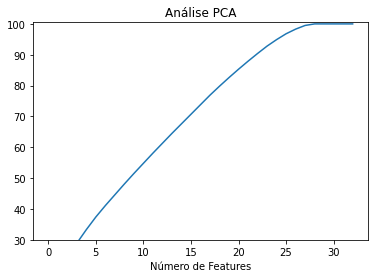

In [16]:
plt.xlabel('Número de Features')
plt.title('Análise PCA')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')

plt.plot(var)

In [17]:
covar_matrix = PCA(n_components = 0.9)
bank_pca = covar_matrix.fit_transform(X_std)
bank_pca = pd.DataFrame(data=bank_pca)
print(bank_pca.shape)
bank_pca['y'] = y

(45211, 23)


## FAMD (Factor Analysis of Mixed Data)
FAMD é uma técnica de redução de dimensionalidade utilizada em um conjunto de dados que contém características quantitativas e qualitativas.

Para utilizarmos essa técnica iremos instalar a pacote Prince e importar a biblioteca FAMD

In [ ]:
!pip install prince
from prince import FAMD 

Para verificarmos o quanto cada componete contribui, faremos o FAMD com a quantidade total de features da base de dados original.

In [19]:
X = bank_full.drop('y', axis=1)

n_features = X.shape[1] # Temos 15 features
famd = FAMD(n_components = n_features, n_iter = 3, random_state = 101)

famd.fit(X)
bank_famd = famd.transform(X)

In [20]:
var_famd=np.cumsum(np.round(famd.explained_inertia_, decimals=3)*100)
var_famd

array([51. , 58.8, 63.8, 68.7, 73.2, 76.3, 79. , 81.1, 82.9, 84.6, 86.2,
       87.7, 89. , 90.1, 91.1])

Na lista acima, vemos que a primeira feature explica 51% da variância em nosso conjunto de dados, enquanto os dois primeiros explicam 58.8, e assim por diante.

Se empregarmos 14 features, capturamos 90,1% da variância dentro do conjunto de dados.

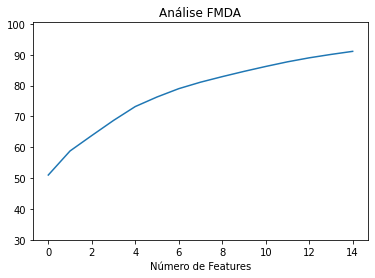

In [21]:
plt.xlabel('Número de Features')
plt.title('Análise FMDA')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')

plt.plot(var_famd)

In [22]:
famd = FAMD(n_components = 14, n_iter = 3, random_state = 101)
famd.fit(X)
bank_famd = famd.transform(X)
bank_famd = pd.DataFrame(data=bank_famd)
print(bank_famd.shape)
bank_famd['y'] = y

(45211, 14)


#Balanceamento

Como vimos anteriormente, as quantidades de instâncias de cada classe são bem diferentes, ou seja, estamos diante de classes desbalanceadas. Faz parte do pré-processamento investir em balanceamento para que o número de instâncias de uma classe equipare-se a da outra.

Como possui relativamente mais instâncias, a classe **no** é chamada de classe majoritária e a classe **yes**, minoritária. A função a seguir cria subconjuntos separados pela classe.





In [23]:
def get_maj_min(bank):
  bank_majority = bank[bank.y=='no']
  bank_minority = bank[bank.y=='yes']

  return bank_majority, bank_minority

##Up-sample Minority Class

A primeira abordagem de balanceamento que será utilizada é conhecida como  Up-sample Minority Class, que visa aumentar o número de instâncias da classe minonitária.

Existem várias formas de fazer isso, mas a maneira mais comum é através de  reamostragem com reposição.

A biblioteca Scikit-Learn oferece o módulo de reamostragem. A função a seguir utiliza o método **resample()** que executa a partir dos seguintes parâmetros:
- informa-se o dataframe de origem das instâncias, no caso o subconjunto da classe minoritária;
- replace=True para garantir que a reamostragem será feita com reposição;
- n_samples informa a quantidade de instâncias que deseja-se atingir, no caso queremos igualar a quantidade de instâncias da classe **no**;
- random_state é um inteiro que garante saída reproduzível quando o comando for executado outras vezes.


In [24]:
from sklearn.utils import resample

def upsample(bank):
  
  bank_majority, bank_minority = get_maj_min(bank)
  n_no = bank_majority.shape[0]

  # Gerando conjunto minoritário ampliado
  minority_up = resample(bank_minority, replace=True,
                         n_samples=n_no, random_state=10)

  # Concatenando o conjunto ampliado ao conjunto majoritário
  bank_upsampled = pd.concat([bank_majority, minority_up])
  
  return bank_upsampled

Dessa forma, para aplicar a técnica, chamamos a função criada **upsample()**, que gera um conjunto minoritário ampliado utilizando o método resample, e então concatena este conjunto ao conjunto majoritário. Podemos verificar que as classes agora estão balanceadas.

In [25]:
bank_upsampled = upsample(bank_full)

u = bank_upsampled.y.value_counts()
print(u)
print(f'O dataframe foi balanceado utilizando Up-sample'+
      f' e agora conta com {u.sum()} exemplos.')

yes    39922
no     39922
Name: y, dtype: int64
O dataframe foi balanceado utilizando Up-sample e agora conta com 79844 exemplos.


##Down-sample Majority Class

Uma outra opção de balanceamento é conhecida como  Down-sample Majority Class, que visa diminuir o número de instâncias da classe majoritária.

Agora utilizando reamostragem sem reposição, sortearemos instâncias da classe **no** para removê-las.

A função a seguir também utiliza o método **resample()**, mas note que dessa vez:
- informa-se o dataframe de origem das instâncias, no caso o subconjunto da classe majoritária;
- replace=False para garantir que a reamostragem será feita sem reposição;
- n_samples informa a quantidade de instâncias da classe **yes**, para igualar o número;



In [26]:
from sklearn.utils import resample

def downsample(bank):
  
  bank_majority, bank_minority = get_maj_min(bank)
  n_yes = bank_minority.shape[0]

  # Gerando conjunto majoritário reduzido
  majority_down = resample(bank_majority, replace=False,
                           n_samples=n_yes, random_state=10)

  # Concatenando o conjunto reduzido ao conjunto minoritário
  bank_downsampled = pd.concat([majority_down, bank_minority])
  
  return bank_downsampled

Similarmente, para aplicar a técnica, chamamos a função criada **downsample()**, que gera um conjunto majoritário reduzido, e seguida, concatena este conjunto ao conjunto minoritário. Podemos verificar que as classes agora estão balanceadas.

In [27]:
bank_downsampled = downsample(bank_full)
d = bank_downsampled.y.value_counts()

print(d)
print(f'O dataframe foi balanceado utilizando Down-sample' +
      f' e agora conta com {d.sum()} exemplos.')

no     5289
yes    5289
Name: y, dtype: int64
O dataframe foi balanceado utilizando Down-sample e agora conta com 10578 exemplos.


##SMOTE

É também interessante observar a aplicação da técnica SMOTE (Synthetic Minority Over-sampling) para balanceamento. Ela consiste em uma abordagem Up-sample, porém as instâncias da classe minoritária não apenas são repetidas no subconjunto, alguns valores dos atributos são modificados/calculados, criando "novas" instâncias artificiais.

A fim de utilizar essa técnica, é preciso instalar a bilioteca imbalanced-learn.

In [ ]:
!pip install -U imbalanced-learn

Os comandos na função a seguir, primeiramente, separam os atributos e a classe do conjunto de dados nas variáveis X e y, respectivamente.

Depois, se o banco de dados tiver apenas variáveis numéricas usamos a classe SMOTE(). Caso o banco de dados tenha variáveis categóricas também, é possível utilizar a classe SMOTENC, que consegue lidar com atributos nominais e contínuos, informando por parâmetro as colunas de atributos categóricos.

Por fim, é possível equilibrar a classe minoritária, transformando o conjunto de dados em um conjunto balanceado, por meio do método fit_resample.


In [29]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
# Em caso de erro no import, é necessário reiniciar o ambiente de execução

def smote(bank, cf=[]):
  y = bank.y
  X = bank.drop('y', axis=1)

  if cf == []:
    smote = SMOTE()
  else:
    smote = SMOTENC(categorical_features=cf)

  X, y = smote.fit_resample(X, y)

  # Concatenando a coluna da classe de volta ao conjunto de dados dos atributos
  bank_smote = X
  bank_smote['y'] = y

  return bank_smote

Agora chamamos a função informando o banco que desejameos balancear e os indíces das variáveis (se for o caso), observa-se o novo conjunto balanceado.

In [30]:
cf_index =[1, 2, 3, 4, 6, 7, 8, 10, 14]
bank_smote = smote(bank_full, cf_index)

s = bank_smote.y.value_counts()

print(s)
print(f'O dataframe foi balanceado utilizando Smote e agora conta com {s.sum()} exemplos.')

yes    39922
no     39922
Name: y, dtype: int64
O dataframe foi balanceado utilizando Smote e agora conta com 79844 exemplos.


É recomendado combinar SMOTE com subamostragem aleatória da classe majoritária. A biblioteca imbalanced-learn oferece suporte à subamostragem aleatória por meio da classe RandomUnderSampler.

Dessa forma, escolheu-se primeiro ampliar a classe minoritária para ter metade do número de instâncias da classe majoritária. Depois, decidiu-se diminuir pela metade a classe **no** para igualar-se a classe **yes**.

Cria-se então um pipeline com as operações que desejamos realizar. Por fim, aplica-se o pipeline ao conjunto de dados com os atributos separados pelas variáveis X e y.



In [31]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

def smote_under(bank, cf=[], sampling_strategy=0.5):
  # Configurando a sobreamostragem para 50% e a submostragem.
  if cf==[]:
    over = SMOTE(sampling_strategy = sampling_strategy)
  else:  
    over = SMOTENC(categorical_features= cf,
                   sampling_strategy = sampling_strategy)
  under = RandomUnderSampler()

  # Criando o pipeline
  steps = [('o', over), ('u', under)]
  pipeline = Pipeline(steps=steps)

  # Separando a classe dos atributos
  y = bank.y
  X = bank.drop('y', axis=1)

  # Aplicando o pipeline
  X, y = pipeline.fit_resample(X, y)

  # Concatenando a coluna da classe de volta 
  bank_smote_under = X
  bank_smote_under['y'] = y

  return bank_smote_under

Para observar o resultado, é possível contabilizar o novo conjunto balanceado da seguinte forma.

In [32]:
cf_index =[1, 2, 3, 4, 6, 7, 8, 10, 14]
bank_smote_under = smote_under(bank_full, cf_index)

su = bank_smote_under.y.value_counts()

print(su)
print(f'O dataframe foi balanceado utilizando Smote e agora conta com {su.sum()} exemplos.')

no     19961
yes    19961
Name: y, dtype: int64
O dataframe foi balanceado utilizando Smote e agora conta com 39922 exemplos.


#Arquivos .csv

Para guardar as bases de dados pré-processados, salvamos em .csv e utilizamos o download de arquivos. As linhas para download estão comentadas. Para baixar os bancos que desejar, basta remover o símbolo de comentário na(s) linha(s) e executar. 

In [33]:
from google.colab import files

A seguir, vamos salvar a base de dados com as variáveis númericas em um arquivo csv.

In [34]:
bank_num.to_csv('bank_num.csv') 
#files.download('bank_num.csv')

Salvaremos também as versões após a redução de dimensionalidade com PCA e FAMD.

In [35]:
bank_pca.to_csv('bank_pca.csv') 
#files.download('bank_pca.csv')

bank_famd.to_csv('bank_famd.csv') 
#files.download('bank_famd.csv')

Salvaremos ainda as versões balancedas do banco original e dos bancos acima com as quatro técnicas de balanceamento utilizadas.

In [36]:
from google.colab import files

# Bancos balanceados a partir de bank_full
bank_upsampled.to_csv('bank_upsampled.csv') 
#files.download('bank_upsampled.csv')

bank_downsampled.to_csv('bank_downsampled.csv') 
#files.download('bank_downsampled.csv')

bank_smote.to_csv('bank_smote.csv') 
#files.download('bank_smote.csv')

bank_smote_under.to_csv('bank_smote_under.csv') 
#files.download('bank_smote_under.csv')

In [37]:
from google.colab import files

# Bancos balanceados a partir de bank_num
bank_num_upsampled = upsample(bank_num)
bank_num_upsampled.to_csv('bank_num_upsampled.csv') 
#files.download('bank_num_upsampled.csv')

bank_num_downsampled = downsample(bank_num)
bank_num_downsampled.to_csv('bank_num_downsampled.csv') 
#files.download('bank_num_downsampled.csv')

bank_num_smote = smote(bank_num)
bank_num_smote.to_csv('bank_num_smote.csv') 
#files.download('bank_num_smote.csv')

bank_num_smote_under = smote_under(bank_num)
bank_num_smote_under.to_csv('bank_num_smote_under.csv') 
#files.download('bank_num_smote_under.csv')

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [38]:
from google.colab import files

# Bancos balanceados a partir de bank_pca
bank_pca_upsampled = upsample(bank_pca)
bank_pca_upsampled.to_csv('bank_pca_upsampled.csv') 
#files.download('bank_pca_upsampled.csv')

bank_pca_downsampled = downsample(bank_pca)
bank_pca_downsampled.to_csv('bank_pca_downsampled.csv') 
#files.download('bank_pca_downsampled.csv')

bank_pca_smote = smote(bank_pca)
bank_pca_smote.to_csv('bank_pca_smote.csv') 
#files.download('bank_pca_smote.csv')

bank_pca_smote_under = smote_under(bank_pca)
bank_pca_smote_under.to_csv('bank_pca_smote_under.csv') 
#files.download('bank_pca_smote_under.csv')

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [39]:
from google.colab import files

# Bancos balanceados a partir de bank_famd
bank_famd_upsampled = upsample(bank_famd)
bank_famd_upsampled.to_csv('bank_famd_upsampled.csv') 
#files.download('bank_famd_upsampled.csv')

bank_famd_downsampled = downsample(bank_famd)
bank_famd_downsampled.to_csv('bank_famd_downsampled.csv') 
#files.download('bank_famd_downsampled.csv')

bank_famd_smote = smote(bank_famd)
bank_famd_smote.to_csv('bank_famd_smote.csv') 
#files.download('bank_famd_smote.csv')

bank_famd_smote_under = smote_under(bank_famd)
bank_famd_smote_under.to_csv('bank_famd_smote_under.csv') 
#files.download('bank_famd_smote_under.csv')

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
